In [1]:
# =========================
# WISDM Activity Analysis (두 행동을 abnormal로 통합)
# 구조: Import -> Load/Preprocess -> Shape/Null -> Label Dist -> Numeric Stats
#      -> Train/Test Split -> Pipeline(Model) -> Metrics -> Confusion Matrix -> Feature Importances
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
# --- Plot helpers ---
def plot_bar_counts(series, title, xlabel, ylabel):
    counts = series.value_counts().sort_index()
    plt.figure()
    counts.plot(kind='bar', rot=45)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure()
    _ = plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [3]:
# ---------------------------
# 1) 데이터 로드 및 전처리
# ---------------------------
csv_path = "/content/drive/MyDrive/Col/머신러닝 11주차/WISDM.csv"

# 헤더 없는 CSV일 가능성 고려
try:
    df_try = pd.read_csv(csv_path, header=None)
    if df_try.shape[1] == 7:
        df = df_try.copy()
        df.columns = ["index","subject","activity","timestamp","x","y","z"]
    elif df_try.shape[1] == 5:
        df = df_try.copy()
        df.columns = ["index","activity","x","y","z"]
    else:
        df = pd.read_csv(csv_path)
except Exception:
    df = pd.read_csv(csv_path)

# subject, timestamp 제거
for col in ["subject","timestamp"]:
    if col in df.columns:
        df = df.drop(columns=[col])

print("컬럼:", df.columns.tolist())
display(df.head())

컬럼: ['index', 'activity', 'x', 'y', 'z']


,index,activity,x,y,z
0,0,Jogging,-0.694638,12.680544,0.503953
1,1,Jogging,5.012288,11.264028,0.953424
2,2,Jogging,4.903325,10.882658,-0.081722
3,3,Jogging,-0.612916,18.496431,3.023717
4,4,Jogging,-1.184970,12.108489,7.205164


In [4]:
# ---------------------------
# 2) 두 행동을 abnormal로 변경
# ---------------------------
df['activity'] = df['activity'].replace(['Standing', 'Jogging'], 'abnormal')
print("클래스별 샘플 수:")
print(df['activity'].value_counts())

클래스별 샘플 수:
activity
Walking       406775
abnormal      370522
Upstairs      118589
Downstairs     97813
Sitting        54876
Name: count, dtype: int64


In [5]:
# ---------------------------
# 3) 결측치 및 데이터 크기 확인
# ---------------------------
print("데이터 크기:", df.shape)
print("결측치:\n", df.isnull().sum())

데이터 크기: (1048575, 5)
결측치:
 index       0
activity    0
x           0
y           0
z           0
dtype: int64


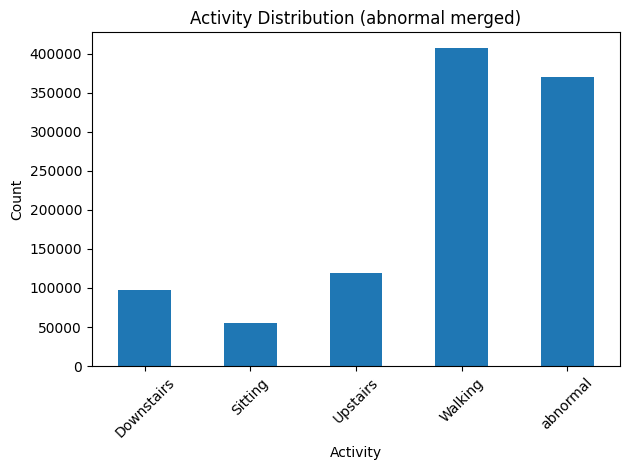

In [6]:
# ---------------------------
# 4) 라벨 분포 시각화
# ---------------------------
plot_bar_counts(df['activity'], title="Activity Distribution (abnormal merged)", xlabel="Activity", ylabel="Count")

In [7]:
# ---------------------------
# 5) 수치형 특징 확인
# ---------------------------
num_cols = [c for c in df.columns if c not in ["activity","index"] and np.issubdtype(df[c].dtype, np.number)]
print("수치형 특징:", num_cols)
display(df[num_cols].describe().T)

수치형 특징: ['x', 'y', 'z']


,count,mean,std,min,25%,50%,75%,max
x,1048575.0,0.797495,6.733040,-19.61,-2.640000,0.38,4.480000,19.95
y,1048575.0,7.379897,6.690966,-19.61,3.340000,8.05,11.650000,20.04
z,1048575.0,0.427549,4.794061,-19.80,-2.220117,0.00,2.764931,19.61


In [8]:
# ---------------------------
# 6) 특징/라벨 분리 및 인코딩
# ---------------------------
X = df[num_cols]
y_raw = df['activity']

le = LabelEncoder()
y = le.fit_transform(y_raw)
class_names = le.classes_.tolist()
print("클래스 매핑:", {cls:i for i, cls in enumerate(class_names)})

클래스 매핑: {'Downstairs': 0, 'Sitting': 1, 'Upstairs': 2, 'Walking': 3, 'abnormal': 4}


In [9]:
# ---------------------------
# 7) Train/Test 분리
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train/Test shapes:", X_train.shape, X_test.shape)

Train/Test shapes: (838860, 3) (209715, 3)


In [10]:
# ---------------------------
# 8) 파이프라인 (표준화 + 랜덤포레스트)
# ---------------------------
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [11]:
# ---------------------------
# 9) 평가
# ---------------------------
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc, 4))
print("\nClassification Report\n", classification_report(y_test, y_pred, target_names=class_names))

Accuracy: 0.6361

Classification Report
               precision    recall  f1-score   support

  Downstairs       0.34      0.13      0.19     19563
     Sitting       0.98      0.98      0.98     10975
    Upstairs       0.35      0.15      0.21     23718
     Walking       0.59      0.77      0.67     81355
    abnormal       0.72      0.73      0.72     74104

    accuracy                           0.64    209715
   macro avg       0.60      0.55      0.55    209715
weighted avg       0.61      0.64      0.61    209715



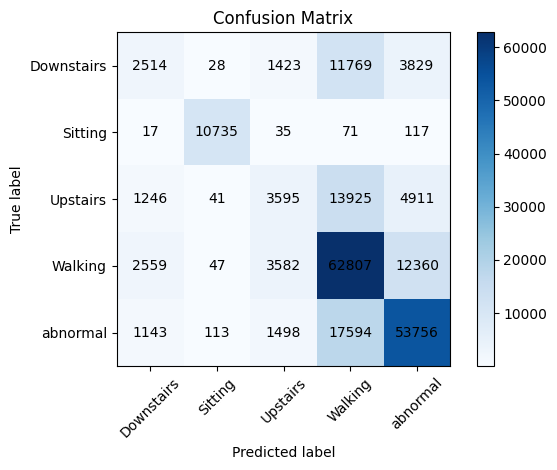

In [12]:
# ---------------------------
# 10) 혼동행렬
# ---------------------------
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names)

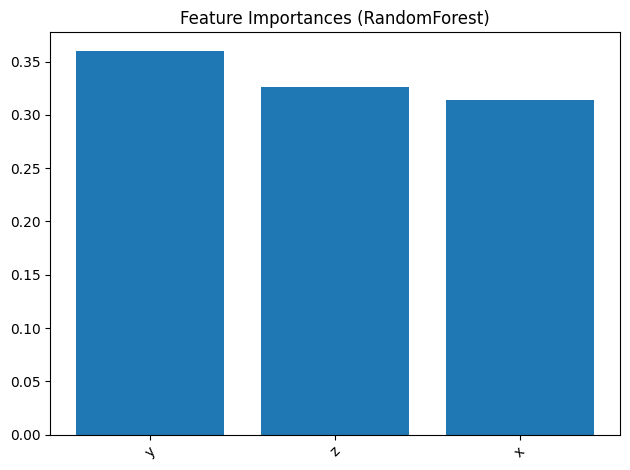

In [13]:
# ---------------------------
# 11) 특징 중요도 시각화
# ---------------------------
try:
    importances = pipe.named_steps["clf"].feature_importances_
    order = np.argsort(importances)[::-1]
    plt.figure()
    plt.bar(range(len(importances)), importances[order])
    plt.xticks(range(len(importances)), np.array(X.columns)[order], rotation=45)
    plt.title("Feature Importances (RandomForest)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Feature importances not available:", e)